In [25]:
# =============================================================================
# GERMAN CREDIT RISK PREDICTION
# Dataset: https://www.kaggle.com/datasets/uciml/german-credit
# Target: Synthetically derived 'Risk' (0=Good, 1=Bad) based on heuristics
# Models: Logistic Regression, Random Forest, XGBoost + Deep Neural Network
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Force permanent plots and styling
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# ====================== 1. LOAD DATASET ======================
df = pd.read_csv("german_credit_data.csv", index_col=0)  # First column is index

print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Dataset loaded successfully!
Shape: (1000, 9)

Columns: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']

First 5 rows:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [26]:
# ====================== 2. DERIVE SYNTHETIC TARGET 'Risk' ======================
# Heuristic: High credit/short duration OR risky purpose
# This is an approximation since no target exists

df['Credit_to_Duration_Ratio'] = df['Credit amount'] / (df['Duration'] + 1)  # +1 to avoid div/0

# Risky purposes (based on common credit patterns)
risky_purposes = ['business', 'education']
df['Risky_Purpose'] = df['Purpose'].isin(risky_purposes).astype(int)

# Synthetic Risk: 1 if high ratio (>1000) OR risky purpose
df['Risk'] = ((df['Credit_to_Duration_Ratio'] > 1000) | (df['Risky_Purpose'] == 1)).astype(int)

print("Synthetic 'Risk' column created (0=Good, 1=Bad)")
print("Risk distribution:")
print(df['Risk'].value_counts())
print(f"Bad credit rate: {df['Risk'].mean():.2%}")

# Drop temporary columns if not needed for modeling
df = df.drop(['Credit_to_Duration_Ratio', 'Risky_Purpose'], axis=1)

Synthetic 'Risk' column created (0=Good, 1=Bad)
Risk distribution:
Risk
0    842
1    158
Name: count, dtype: int64
Bad credit rate: 15.80%


=== DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 85.9+ KB
None

=== MISSING VALUES ===
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: in

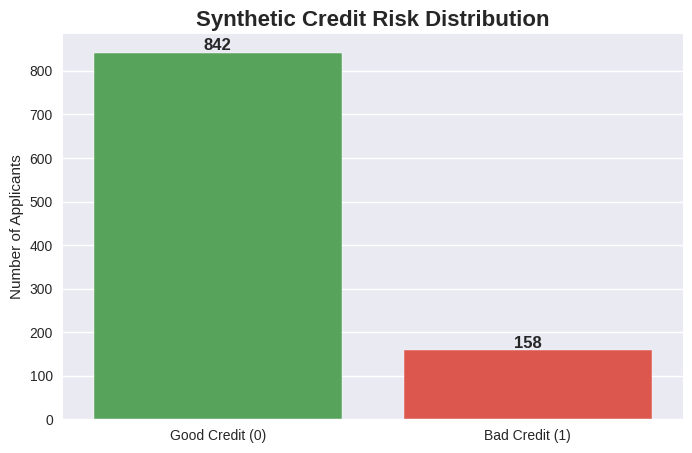


Good: 842 (84.2%) | Bad: 158 (15.8%)


In [27]:
# ====================== 3. EXPLORATORY DATA ANALYSIS (EDA) ======================

print("=== DATA INFO ===")
print(df.info())
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

# Handle missing values
df['Saving accounts'] = df['Saving accounts'].fillna('none')
df['Checking account'] = df['Checking account'].fillna('none')

# Plot 1: Target Distribution (permanent plot)
plt.figure(figsize=(8,5))
risk_counts = df['Risk'].value_counts().sort_index()
ax = sns.countplot(data=df, x='Risk', palette=['#4CAF50', '#F44336'])
ax.set_title('Synthetic Credit Risk Distribution', fontsize=16, fontweight='bold')
ax.set_xticklabels(['Good Credit (0)', 'Bad Credit (1)'])
for i, v in enumerate(risk_counts):
    ax.text(i, v + 5, str(v), ha='center', fontweight='bold', fontsize=12)
plt.ylabel('Number of Applicants')
plt.xlabel('')
plt.show()

print(f"\nGood: {risk_counts[0]} ({risk_counts[0]/len(df)*100:.1f}%) | Bad: {risk_counts[1]} ({risk_counts[1]/len(df)*100:.1f}%)")

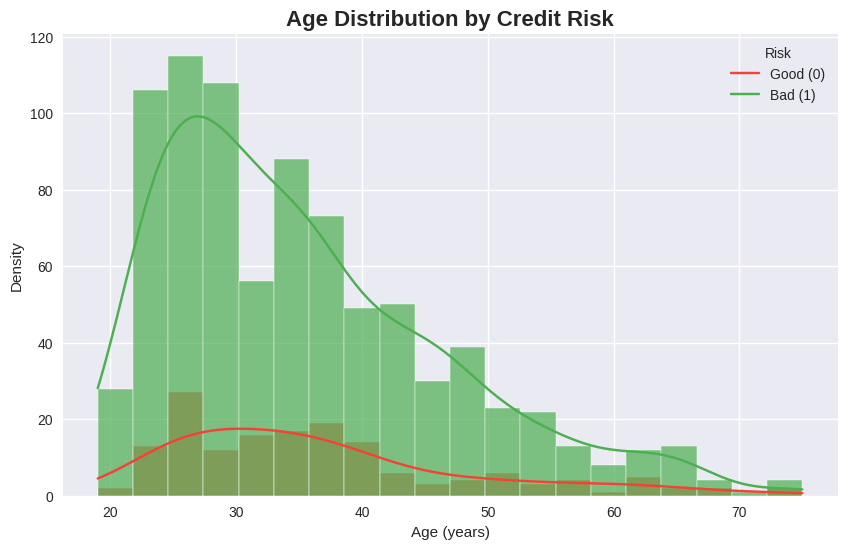

In [28]:
# Plot 2: Age Distribution by Risk
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Age', hue='Risk', bins=20, kde=True, palette=['#4CAF50', '#F44336'], alpha=0.7)
plt.title('Age Distribution by Credit Risk', fontsize=16, fontweight='bold')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend(title='Risk', labels=['Good (0)', 'Bad (1)'])
plt.show()

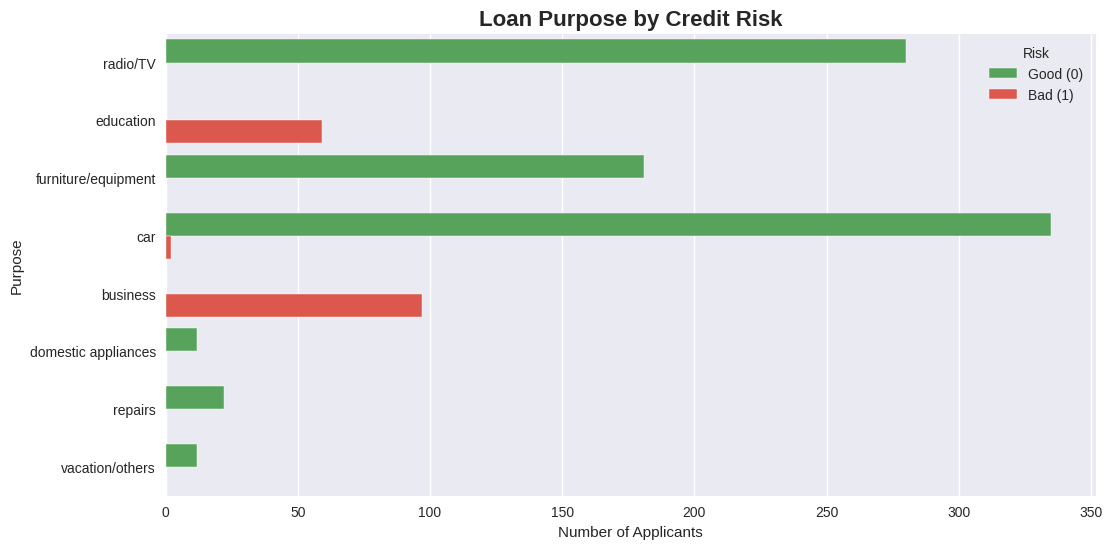

In [29]:
# Plot 3: Purpose Distribution by Risk
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='Purpose', hue='Risk', palette=['#4CAF50', '#F44336'])
plt.title('Loan Purpose by Credit Risk', fontsize=16, fontweight='bold')
plt.xlabel('Number of Applicants')
plt.ylabel('Purpose')
plt.legend(title='Risk', labels=['Good (0)', 'Bad (1)'])
plt.show()

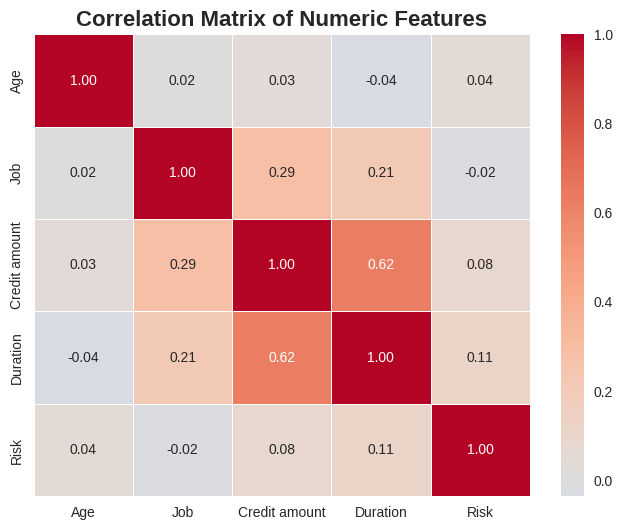

In [30]:
# Plot 4: Correlation Heatmap (Numeric Features)
numeric_cols = ['Age', 'Job', 'Credit amount', 'Duration', 'Risk']
plt.figure(figsize=(8,6))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Numeric Features', fontsize=16, fontweight='bold')
plt.show()

In [31]:
# ====================== 4. DATA PREPROCESSING ======================
# Encode categorical columns
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# Features and target
X = df.drop('Risk', axis=1)
y = df['Risk']

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape[0]} samples")
print(f"Test set: {X_test_scaled.shape[0]} samples")
print(f"Bad risk in train: {y_train.mean():.2%}")

Training set: 800 samples
Test set: 200 samples
Bad risk in train: 15.75%



=== Logistic Regression ===
              precision    recall  f1-score   support

        Good       0.84      1.00      0.92       168
         Bad       1.00      0.03      0.06        32

    accuracy                           0.84       200
   macro avg       0.92      0.52      0.49       200
weighted avg       0.87      0.84      0.78       200

AUC-ROC: 0.8106


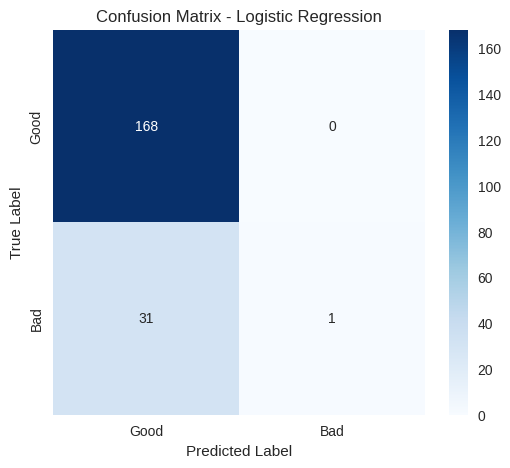


=== Random Forest ===
              precision    recall  f1-score   support

        Good       0.99      1.00      0.99       168
         Bad       1.00      0.94      0.97        32

    accuracy                           0.99       200
   macro avg       0.99      0.97      0.98       200
weighted avg       0.99      0.99      0.99       200

AUC-ROC: 1.0000


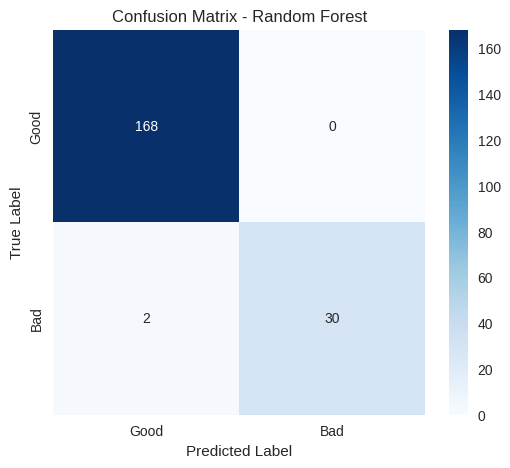


=== XGBoost ===
              precision    recall  f1-score   support

        Good       0.99      1.00      1.00       168
         Bad       1.00      0.97      0.98        32

    accuracy                           0.99       200
   macro avg       1.00      0.98      0.99       200
weighted avg       1.00      0.99      0.99       200

AUC-ROC: 1.0000


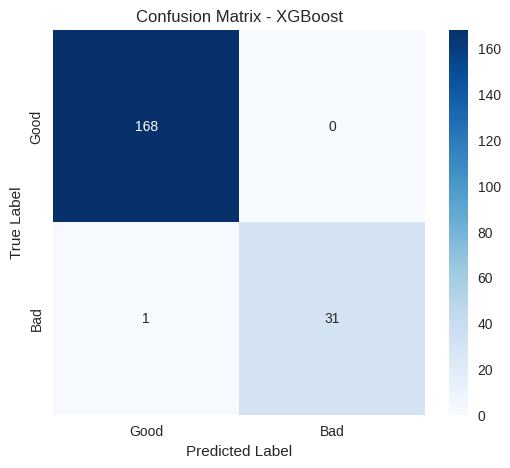

In [32]:
# ====================== 5. MODEL EVALUATION FUNCTION ======================
def evaluate_model(model, X_tr, X_te, y_tr, y_te, name, is_nn=False):
    model.fit(X_tr, y_tr)
    if is_nn:
        y_pred = (model.predict(X_te) > 0.5).astype(int).flatten()
        y_proba = model.predict(X_te).flatten()
    else:
        y_pred = model.predict(X_te)
        y_proba = model.predict_proba(X_te)[:, 1]

    auc = roc_auc_score(y_te, y_proba)
    print(f"\n=== {name} ===")
    print(classification_report(y_te, y_pred, target_names=['Good', 'Bad']))
    print(f"AUC-ROC: {auc:.4f}")

    # Confusion Matrix (permanent plot)
    cm = confusion_matrix(y_te, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return auc

# ====================== 6. BASELINE MODELS ======================

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr_auc = evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_auc = evaluate_model(rf, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")

# XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42, eval_metric='logloss')
xgb_auc = evaluate_model(xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, "XGBoost")

Training Deep Neural Network...
Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5832 - auc: 0.5322 - loss: 0.7038 - val_accuracy: 0.8400 - val_auc: 0.6202 - val_loss: 0.5688
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7018 - auc: 0.6040 - loss: 0.5736 - val_accuracy: 0.8450 - val_auc: 0.7101 - val_loss: 0.5221
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7401 - auc: 0.5762 - loss: 0.5459 - val_accuracy: 0.8400 - val_auc: 0.7504 - val_loss: 0.4828
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7892 - auc: 0.6517 - loss: 0.4704 - val_accuracy: 0.8500 - val_auc: 0.7744 - val_loss: 0.4531
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7669 - auc: 0.6197 - loss: 0.4960 - val_accuracy: 0.8450 - val_auc: 0.7871 - val_loss: 0.4295
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8274 - auc: 0.7177 - loss: 0.4055 - val_accuracy: 0.8400 - val_auc: 0.7909 - val_loss: 0.4102
Epoch 7/1

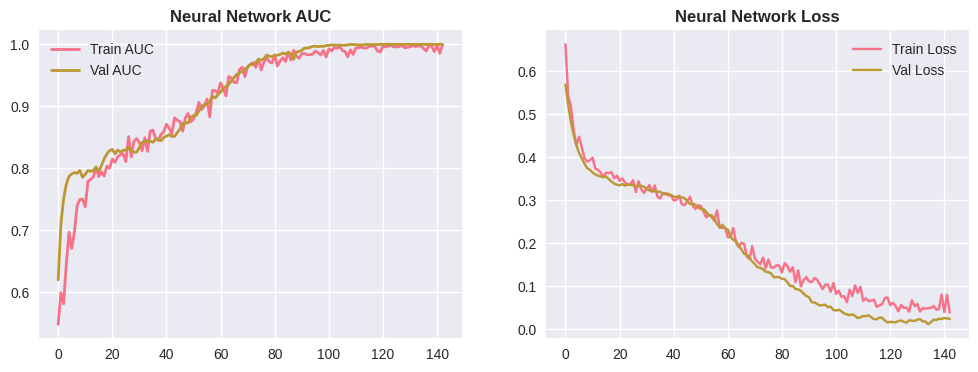

In [33]:
# ====================== 7. DEEP LEARNING MODEL ======================
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=20, restore_best_weights=True, verbose=1)

print("Training Deep Neural Network...")
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot Training History (permanent)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['auc'], label='Train AUC', linewidth=2)
plt.plot(history.history['val_auc'], label='Val AUC', linewidth=2)
plt.title('Neural Network AUC', fontweight='bold')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Neural Network Loss', fontweight='bold')
plt.legend()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9838 - auc: 0.9934 - loss: 0.0588
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

=== Deep Neural Network ===
              precision    recall  f1-score   support

        Good       0.99      1.00      1.00       168
         Bad       1.00      0.97      0.98        32

    accuracy                           0.99       200
   macro avg       1.00      0.98      0.99       200
weighted avg       1.00      0.99      0.99       200

AUC-ROC: 1.0000


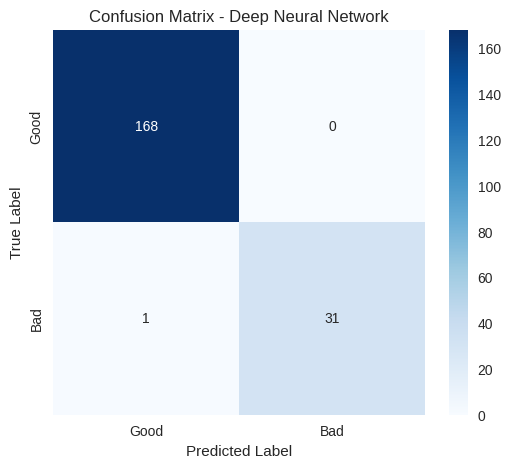

In [34]:
# Evaluate Deep Learning
nn_auc = evaluate_model(nn_model, X_train_scaled, X_test_scaled, y_train, y_test, "Deep Neural Network", is_nn=True)


                  FINAL MODEL PERFORMANCE
              Model  AUC-ROC
      Random Forest   1.0000
            XGBoost   1.0000
Deep Neural Network   1.0000
Logistic Regression   0.8106


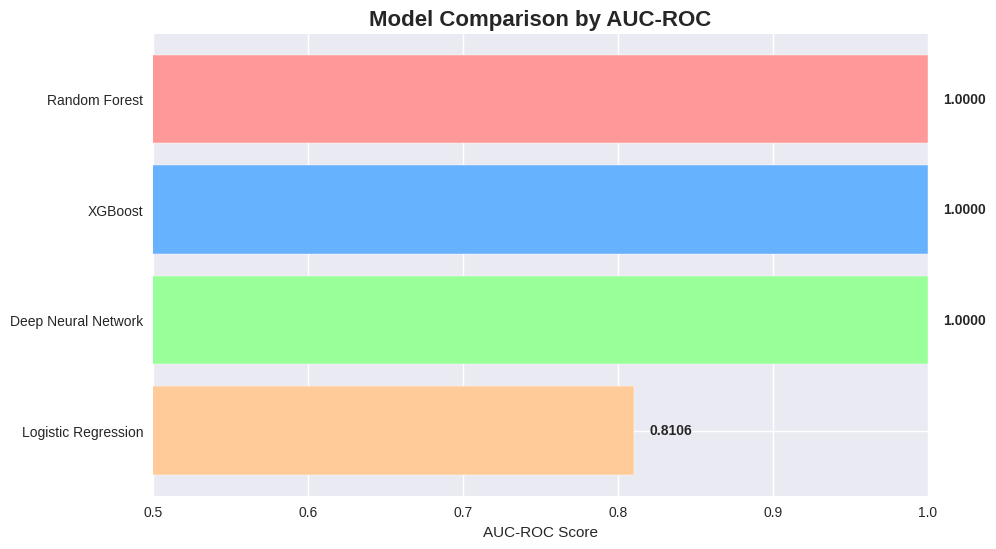

In [35]:
# ====================== 8. FINAL COMPARISON ======================
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Deep Neural Network'],
    'AUC-ROC': [lr_auc, rf_auc, xgb_auc, nn_auc]
}).sort_values('AUC-ROC', ascending=False)

print("\n" + "="*60)
print("                  FINAL MODEL PERFORMANCE")
print("="*60)
print(results_df.to_string(index=False, float_format='%.4f'))

# Comparison Bar Plot (permanent)
plt.figure(figsize=(10,6))
bars = plt.barh(results_df['Model'], results_df['AUC-ROC'], color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])
plt.title('Model Comparison by AUC-ROC', fontsize=16, fontweight='bold')
plt.xlabel('AUC-ROC Score')
plt.xlim(0.5, 1.0)
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{results_df["AUC-ROC"].iloc[i]:.4f}',
             ha='left', va='center', fontweight='bold')
plt.gca().invert_yaxis()
plt.show()